In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from google.colab import drive
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score,precision_score,recall_score,f1_score
import joblib
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import pickle
from sklearn.cluster import KMeans



In [3]:
#drive.mount('/content/drive')
dataset_path = "/content/drive/MyDrive/project/customer_churn.csv"
df = pd.read_csv(dataset_path)
print("Original dataset :",df.shape)
print(df.head())

df.drop("Surname", axis=1, inplace=True)
df.drop("CustomerId", axis=1, inplace=True)
print("Missing value count:")
print(df.isnull().sum())
print("Duplicates count :",df.duplicated().sum())
print("Cleaned dataset",df.shape)

print(df.info())
df = pd.get_dummies(df, columns=["Geography", "Gender"], drop_first=True)
print(df.info())
print("after encoding",df.shape)

Original dataset : (10000, 13)
   CustomerId   Surname  CreditScore Geography  Gender  Age  Tenure  \
0    15634602  Hargrave          619    France  Female   42       2   
1    15647311      Hill          608     Spain  Female   41       1   
2    15619304      Onio          502    France  Female   42       8   
3    15701354      Boni          699    France  Female   39       1   
4    15737888  Mitchell          850     Spain  Female   43       2   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0       0.00              1          1               1        101348.88   
1   83807.86              1          0               1        112542.58   
2  159660.80              3          1               0        113931.57   
3       0.00              2          0               0         93826.63   
4  125510.82              1          1               1         79084.10   

   Exited  
0       1  
1       0  
2       1  
3       0  
4       0  
Missing value count

In [4]:
# Handle outliers using IQR
outlier_cols = ["CreditScore", "Age", "Balance", "EstimatedSalary"] \

for col in outlier_cols:
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1
  df = df[(df[col] >= (Q1 - 2.5 * IQR)) & (df[col] <= (Q3 + 2.5 * IQR))]
print("Shape after outlier handling",df.shape)


Shape after outlier handling (9946, 12)


In [5]:
#Train-test split
X = df.drop(columns=['Exited'])
y = df['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Exited
0    7910
1    2036
Name: count, dtype: int64


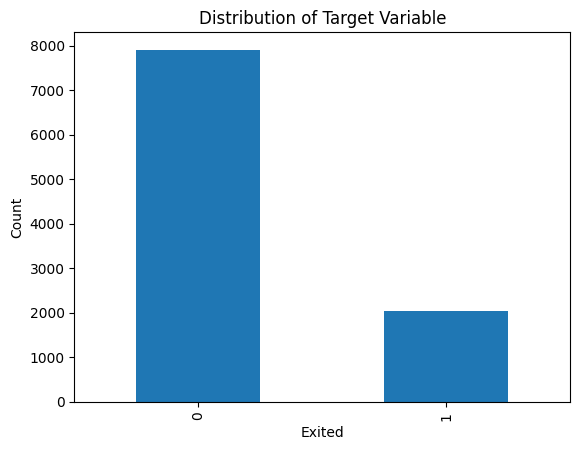

Exited
0    2036
1    2036
Name: count, dtype: int64
balanced dataset (4072, 12)


In [6]:
#check if the dataset is balanced
churn_counts = df["Exited"].value_counts()
print(churn_counts)

df['Exited'].value_counts().plot(kind='bar')
plt.xlabel('Exited')
plt.ylabel('Count')
plt.title('Distribution of Target Variable')
plt.show()

undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)
df = X_resampled.copy()
df["Exited"] = y_resampled
churn_counts = df["Exited"].value_counts()
print(churn_counts)
print("balanced dataset",df.shape)

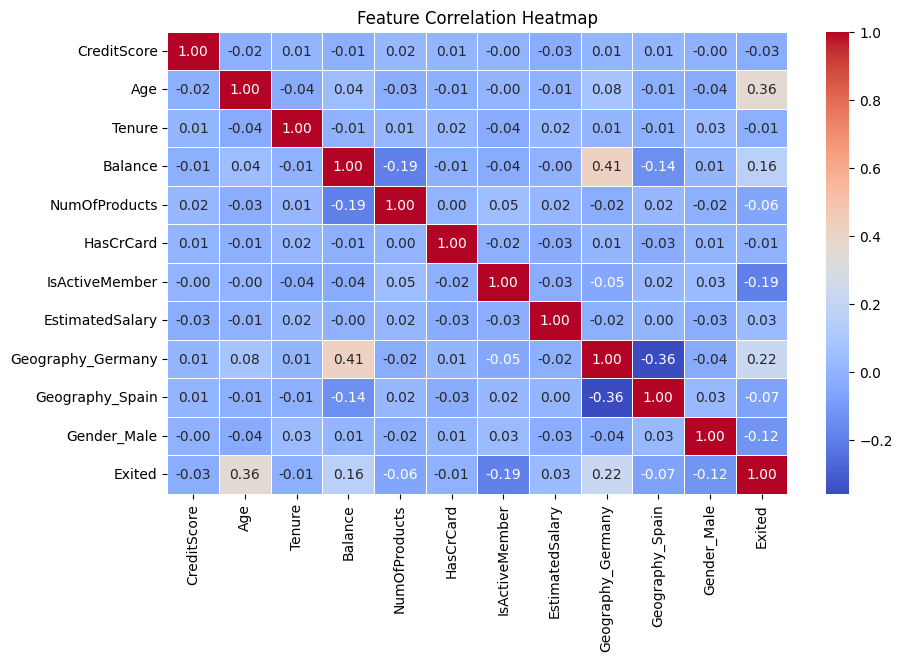

<ipython-input-7-c3dd554f1d40>:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=df["Age"], y=df["Exited"], ci=None, palette="coolwarm")
<ipython-input-7-c3dd554f1d40>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df["Age"], y=df["Exited"], ci=None, palette="coolwarm")


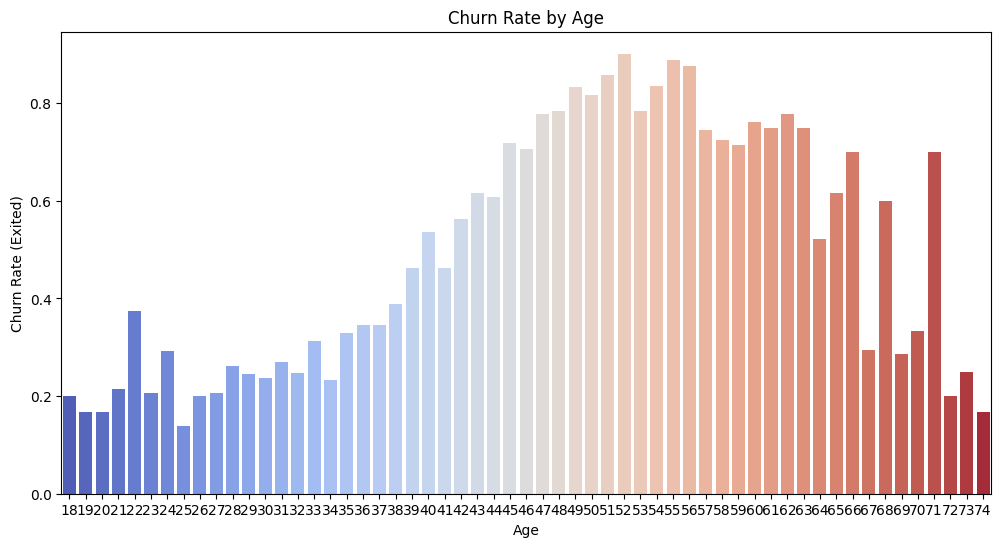

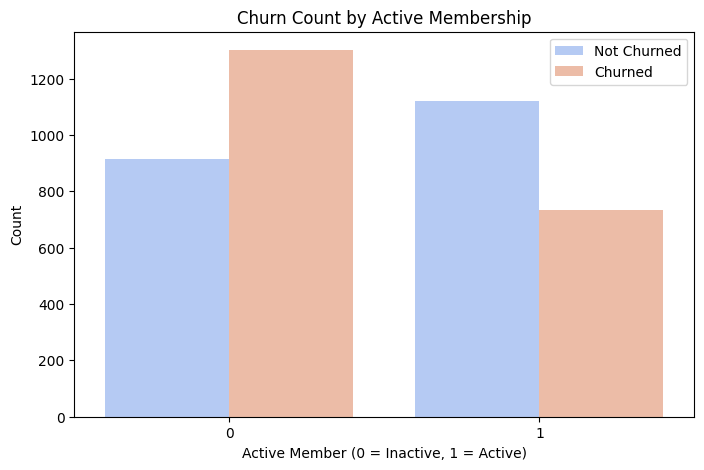

In [7]:
# Correlation heatmap
correlation_matrix = df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x=df["Age"], y=df["Exited"], ci=None, palette="coolwarm")
plt.xlabel("Age")
plt.ylabel("Churn Rate (Exited)")
plt.title("Churn Rate by Age")
plt.show()


plt.figure(figsize=(8, 5))
sns.countplot(x="IsActiveMember", hue="Exited", data=df, palette="coolwarm")
plt.xlabel("Active Member (0 = Inactive, 1 = Active)")
plt.ylabel("Count")
plt.title("Churn Count by Active Membership")
plt.legend(["Not Churned", "Churned"])
plt.show()


In [8]:
#Random forest classifier
# Model Training


param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [8, 10, 12],
    'min_samples_split': [20, 30, 40],
    'min_samples_leaf': [10, 15, 20],
    'class_weight': [{0: 1, 1: 2.0}, {0: 1, 1: 2.5}, {0: 1, 1: 3.0}]
}

random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=40),
    param_distributions=param_grid,
    n_iter=20,  # Tries only 20 random combinations instead of all 405
    cv=3,       # Reducing cross-validation from 5 to 3
    scoring='recall',
    n_jobs=-1,  # Uses all CPU cores to speed up training
    verbose=2
)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print("Best parameters:", best_params)


model = RandomForestClassifier( n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    class_weight=best_params['class_weight'],
    random_state=40)
model.fit(X_train, y_train)


# Predictions
y_pred = model.predict(X_test)
result=pd.DataFrame({'Actual':y_test,'Predicted':y_pred})
print(result)
#Evaluation
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print(cm)


train_acc = model.score(X_train, y_train)
test_acc = model.score(X_test, y_test)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy: {test_acc:.4f}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'n_estimators': 100, 'min_samples_split': 40, 'min_samples_leaf': 10, 'max_depth': 12, 'class_weight': {0: 1, 1: 3.0}}
      Actual  Predicted
8819       0          0
6460       0          0
7936       0          0
9331       0          0
3363       0          0
...      ...        ...
9412       0          0
5369       1          1
453        0          1
5227       0          0
719        0          1

[1990 rows x 2 columns]
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1589
           1       0.58      0.63      0.60       401

    accuracy                           0.83      1990
   macro avg       0.74      0.76      0.75      1990
weighted avg       0.84      0.83      0.84      1990

[[1406  183]
 [ 149  252]]
Training Accuracy: 0.8734
Testing Accuracy: 0.8332


In [9]:
#LogisticRegression

#scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_two = LogisticRegression(class_weight="balanced", solver='saga', max_iter=5000,random_state=42)
model_two.fit(X_train, y_train)

# Predictions
y_pred = model_two.predict(X_test)
result=pd.DataFrame({'Actual':y_test,'Predicted':y_pred})
print(result)

#Evaluation
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print(cm)
train_acc = model_two.score(X_train, y_train)
test_acc = model_two.score(X_test, y_test)
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy: {test_acc:.4f}")

      Actual  Predicted
8819       0          1
6460       0          0
7936       0          0
9331       0          1
3363       0          1
...      ...        ...
9412       0          1
5369       1          1
453        0          1
5227       0          0
719        0          0

[1990 rows x 2 columns]
              precision    recall  f1-score   support

           0       0.85      0.49      0.62      1589
           1       0.24      0.65      0.35       401

    accuracy                           0.52      1990
   macro avg       0.55      0.57      0.49      1990
weighted avg       0.73      0.52      0.57      1990

[[779 810]
 [140 261]]
Training Accuracy: 0.5199
Testing Accuracy: 0.5226


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [15]:
#Comparing two models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n{model_name} Performance:")
    print(classification_report(y_test, y_pred))
    print(f"Confusion Matrix:\n{cm}")
    print(f"Training Accuracy: {model.score(X_train, y_train):.4f}")
    print(f"Testing Accuracy: {acc:.4f}")

    return {
        "Model": model_name,
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    }
rf_results = evaluate_model(model, X_train, X_test, y_train, y_test, "Random Forest")
lr_results = evaluate_model(model_two, X_train_scaled, X_test_scaled, y_train, y_test, "Logistic Regression")

better_model = rf_results if rf_results["F1-Score"] > lr_results["F1-Score"] else lr_results
print(better_model['Model'])
best_model = model if rf_results["F1-Score"] > lr_results["F1-Score"] else model_two


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1589
           1       0.58      0.63      0.60       401

    accuracy                           0.83      1990
   macro avg       0.74      0.76      0.75      1990
weighted avg       0.84      0.83      0.84      1990

Confusion Matrix:
[[1406  183]
 [ 149  252]]
Training Accuracy: 0.8734
Testing Accuracy: 0.8332

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.89      0.60      0.72      1589
           1       0.31      0.71      0.43       401

    accuracy                           0.62      1990
   macro avg       0.60      0.66      0.58      1990
weighted avg       0.77      0.62      0.66      1990

Confusion Matrix:
[[956 633]
 [116 285]]
Training Accuracy: 0.6440
Testing Accuracy: 0.6236
Random Forest


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [16]:
joblib.dump(best_model, "churn_model.pkl")


['churn_model.pkl']

In [17]:
#New predictions
new_data=[
    [700, 35, 5, 12000.0, 2, 1, 1, 50000.0, 1, 0, 1],  # Likely to stay
    [480, 55, 1, 80000.0, 1, 0, 0, 20000.0, 0, 1, 0],  # Likely to churn (low credit, high balance)
    [720, 29, 6, 0.0, 2, 1, 1, 80000.0, 0, 0, 1],  # Likely to stay
    [580, 50, 8, 95000.0, 1, 1, 1, 30000.0, 1, 0, 0],  # Likely to churn (low score, high balance)
    [600, 27, 2, 4000.0, 1, 0, 1, 48000.0, 0, 1, 1],  # Likely to stay
    [750, 34, 7, 15000.0, 2, 1, 0, 72000.0, 1, 0, 0],  # Likely to stay
    [520, 60, 10, 120000.0, 1, 1, 0, 25000.0, 0, 1, 1],  # Likely to churn (old, high balance)
    [710, 42, 4, 100000.0, 2, 1, 0, 65000.0, 1, 0, 1],  # Likely to stay
    [590, 31, 5, 3000.0, 1, 0, 1, 45000.0, 0, 1, 0],  # Likely to stay
    [630, 45, 6, 85000.0, 2, 1, 1, 85000.0, 1, 0, 1]  # Likely to churn (high balance)
]
ndf = pd.DataFrame(new_data, columns=X_train.columns)
print(ndf)
loaded_model = joblib.load("churn_model.pkl")
prediction = loaded_model.predict(ndf)
ndf["Exited"]=prediction
print(ndf)



   CreditScore  Age  Tenure   Balance  NumOfProducts  HasCrCard  \
0          700   35       5   12000.0              2          1   
1          480   55       1   80000.0              1          0   
2          720   29       6       0.0              2          1   
3          580   50       8   95000.0              1          1   
4          600   27       2    4000.0              1          0   
5          750   34       7   15000.0              2          1   
6          520   60      10  120000.0              1          1   
7          710   42       4  100000.0              2          1   
8          590   31       5    3000.0              1          0   
9          630   45       6   85000.0              2          1   

   IsActiveMember  EstimatedSalary  Geography_Germany  Geography_Spain  \
0               1          50000.0                  1                0   
1               0          20000.0                  0                1   
2               1          80000.0      

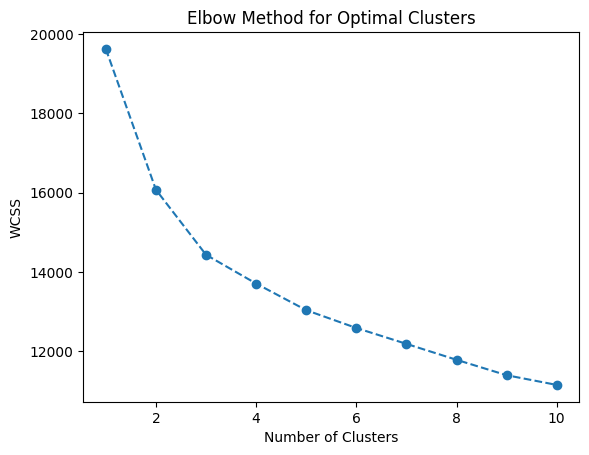

         CreditScore        Age    Tenure        Balance  NumOfProducts  \
Cluster                                                                   
0         649.196347  44.856925  4.974125  120733.681842       1.462709   
1         651.290909  44.148485  4.693939   74540.730273       1.524242   
2         641.788580  45.016975  4.987654   70338.207299       1.501543   

         HasCrCard  IsActiveMember  EstimatedSalary  Geography_Germany  \
Cluster                                                                  
0         0.706240        0.372907     99037.760776                1.0   
1         0.675758        0.345455    104871.061091                0.0   
2         0.699074        0.368827    103605.778364                0.0   

         Geography_Spain  Gender_Male  
Cluster                                
0                    0.0     0.442922  
1                    1.0     0.439394  
2                    0.0     0.430556  


In [24]:
#Clustering churners
churners = X_train[y_train == 1]
churners = churners.copy()  # Make a copy before modifying
churners["Cluster"] = clusters


scaler = StandardScaler()
churners_scaled = scaler.fit_transform(churners)

wcss = []  # Within-cluster sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(churners_scaled)
    wcss.append(kmeans.inertia_)

# Plot Elbow Method graph
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal Clusters')
plt.show()

k = 3  # Based on the elbow method
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(churners_scaled)

# Add the cluster labels to the dataset
churners["Cluster"] = clusters


import pandas as pd

# Convert back to DataFrame
churners_df = pd.DataFrame(churners, columns=X_train.columns)
churners_df["Cluster"] = clusters

# Check mean values for each cluster
cluster_summary = churners_df.groupby("Cluster").mean()
print(cluster_summary)
